In [13]:
from google.colab import drive
drive.mount('/content/gdrive' )
%cd '/content/gdrive/My Drive/Comp4107 Project'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Comp4107 Project


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf

In [0]:


from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.layers import Input, Dense,Lambda, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K


In [0]:
import time
def run_results(ae,args):
    final_loss=[]
    times =[]
    for i in range(1,6):
        model = ae(*args)
        # model.summary()
        train_X_fold = np.load("ML-1M/train"+str(i)+".npy")
        test_X_fold = np.load("ML-1M/test"+str(i)+".npy")
        # model.compile( optimizer='rmsprop', loss=rmse)
        t1 = time.process_time()
        losses = model.fit(train_X_fold, train_X_fold,
                        epochs=300, 
                        batch_size=256,
                        shuffle=True,
                        validation_data=(train_X_fold , test_X_fold)) 
        t2 = time.process_time()
        final_loss.append(losses.history["val_rmse"][299])
        del model #memory saving
        times.append(t2-t1)
    return np.array(final_loss),np.array(times)

In [0]:
#https://stackoverflow.com/questions/44666098/how-to-implement-sparse-mean-squared-error-loss-in-keras MMSE


def rmse(y_true, y_pred):
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_squared_error, axis=-1) / K.sum(mask_true, axis=-1)
    return K.sqrt(masked_mse)

def mmse(y_true, y_pred):
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sum(masked_squared_error, axis=-1) / K.sum(mask_true, axis=-1)
    return (masked_mse)

In [0]:
train_X = np.load("ML-1M/train1.npy")
test_X = np.load("ML-1M/test1.npy")

In [0]:
def run_experiments(models,title, x_train=train_X, x_test=test_X, epochs=150,start=5):
  plt.figure(figsize=(10,8))
  iters = np.arange(start,epochs)
  for i in range(len(models)):
    model = models[i][0]
    # model.compile(optimizer='rmsprop', loss=rmse)
    label = models[i][1]
    losses = model.fit(x_train, x_train, 
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_train , x_test))
    val_loss= np.array(losses.history["val_rmse"])
    plt.plot(iters,val_loss[start:],label=label)
  
  plt.legend()
  # plt.ylim(top=0.7)
  plt.title(title,fontsize=20)
  plt.ylabel("Validation Loss")
  plt.xlabel("Epochs")
  plt.savefig(title+".png")

  plt.show()

# Variational Autoencoders


In [0]:
#from https://keras.io/examples/variational_autoencoder/

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [0]:
def VAE(X,intermediate_dim,latent_dim):


    original_dim =train_X.shape[1]
    input_shape = (original_dim, )

    
    inputs = Input(shape=input_shape)
    x = Dense(intermediate_dim, activation='selu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    # encoder.summary()

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='selu')(latent_inputs)
    outputs = Dense(original_dim, activation='selu')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    # decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs))
    vae = Model(inputs, outputs, name='vae_mlp')

    reconstruction_loss = rmse(inputs, outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(2*reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    vae.compile(optimizer='rmsprop',metrics=[rmse])
    return vae

In [0]:
print("hi")

hi


Epoch 1/200
24/24 [==============================] - 0s 17ms/step - loss: 10725.8623 - rmse: 1.6082 - val_loss: 7131.5562 - val_rmse: 1.0667
Epoch 2/200
24/24 [==============================] - 0s 12ms/step - loss: 6768.7637 - rmse: 1.0125 - val_loss: 6481.0405 - val_rmse: 0.9735
Epoch 3/200
24/24 [==============================] - 0s 12ms/step - loss: 6438.7930 - rmse: 0.9678 - val_loss: 6163.3555 - val_rmse: 0.9281
Epoch 4/200
24/24 [==============================] - 0s 12ms/step - loss: 6236.9399 - rmse: 0.9400 - val_loss: 5897.4155 - val_rmse: 0.8902
Epoch 5/200
24/24 [==============================] - 0s 12ms/step - loss: 6058.5083 - rmse: 0.9143 - val_loss: 5777.3716 - val_rmse: 0.8708
Epoch 6/200
24/24 [==============================] - 0s 12ms/step - loss: 5835.7422 - rmse: 0.8798 - val_loss: 5952.1499 - val_rmse: 0.8992
Epoch 7/200
24/24 [==============================] - 0s 12ms/step - loss: 5628.0547 - rmse: 0.8501 - val_loss: 5408.5894 - val_rmse: 0.8183
Epoch 8/200
24/24 [

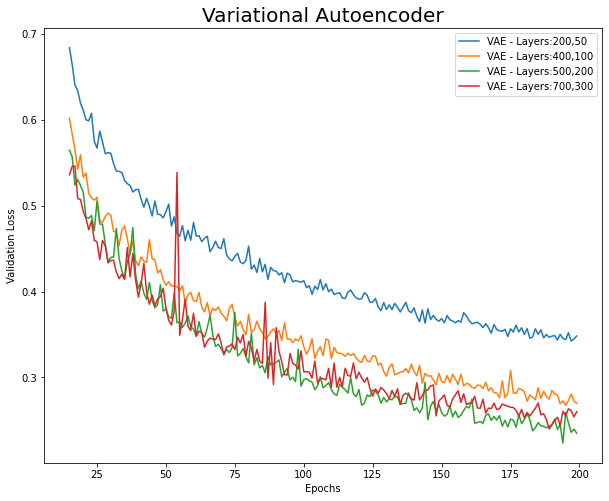

In [42]:
experiments = [(VAE(train_X,200,50),"VAE - Layers:200,50 "),
               (VAE(train_X,400,100),"VAE - Layers:400,100"),
               (VAE(train_X,500,200),"VAE - Layers:500,200"),
               (VAE(train_X,700,300),"VAE - Layers:700,300")
              ]

run_experiments(models=experiments,title="Variational Autoencoder",x_train=train_X,x_test=test_X,
                epochs=200,start=15)    

In [45]:
args=[train_X,500,200]
loos,tims = run_results( VAE,args) 


Epoch 1/300
24/24 [==============================] - 0s 17ms/step - loss: 17252.3809 - rmse: 1.6117 - val_loss: 136171.8281 - val_rmse: 1.0519
Epoch 2/300
24/24 [==============================] - 0s 13ms/step - loss: 28251.9160 - rmse: 1.0446 - val_loss: 38239084.0000 - val_rmse: 0.9683
Epoch 3/300
24/24 [==============================] - 0s 13ms/step - loss: 42179320.0000 - rmse: 0.9741 - val_loss: 231242.1875 - val_rmse: 0.8987
Epoch 4/300
24/24 [==============================] - 0s 13ms/step - loss: 231403.6094 - rmse: 0.9210 - val_loss: 6064.5190 - val_rmse: 0.8941
Epoch 5/300
24/24 [==============================] - 0s 13ms/step - loss: 6427.3169 - rmse: 0.9125 - val_loss: 5724.2749 - val_rmse: 0.8160
Epoch 6/300
24/24 [==============================] - 0s 13ms/step - loss: 5670.4556 - rmse: 0.8232 - val_loss: 5787.0396 - val_rmse: 0.8394
Epoch 7/300
24/24 [==============================] - 0s 12ms/step - loss: 5616.5298 - rmse: 0.8122 - val_loss: 5065.8291 - val_rmse: 0.7460
Epoc

In [49]:
print(loos.mean())
print(2*loos.std()/5**0.5)
print(tims.mean())
print(2*tims.std()/5**0.5)

0.22070567905902863
0.0048162490950438295
160.92898730780007
1.6142590127216214
